In [1]:
import tensorflow as tf
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras import layers
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing import image
import cv2
import os
from tensorflow.keras.models import Model


In [2]:
# To try: data augmentation to increase the size of my data set and kaggle dataset. 
# Try to make a new dataset on white background only and train the model to see if it can learn the pattern.
# Idea: learn the pattern on white background so it is easy and we are sure it learns the pattern.



In [3]:
gpu_details = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpu_details:
    print(gpu)


PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [4]:
combination_ds = keras.utils.image_dataset_from_directory(
    'combination_dataset',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=16,
    image_size=(150, 150),
    shuffle=True
   
)

Found 320 files belonging to 4 classes.


In [5]:
dataset = keras.utils.image_dataset_from_directory(
    'kaggle_dataset_cropped',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=16,
    image_size=(150, 150),
    shuffle=True
   
)

Found 7226 files belonging to 4 classes.


In [6]:
fine_tune_ds = keras.utils.image_dataset_from_directory(
    'my_images',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=16,
    image_size=(150, 150),
    shuffle=True
)

Found 161 files belonging to 4 classes.


In [7]:
# # RUN IF .IPYNB CHECKPOINTS AND CORRUPT DATA SET
# import shutil

# data_dir = "my_images"

# for root, dirs, files in os.walk(data_dir):
#     for dir_name in dirs:
#         if dir_name == ".ipynb_checkpoints":
#             checkpoint_path = os.path.join(root, dir_name)
#             shutil.rmtree(checkpoint_path)  # Delete the folder
#             print(f"Deleted: {checkpoint_path}")


In [8]:
from collections import Counter

all_labels = []
for elements, labels in dataset:
    # print(labels)
    all_labels.extend(labels.numpy())
label_counts = Counter(all_labels)

class_names = dataset.class_names 
# Map class indices to their names
for class_idx, count in label_counts.items():
    print(f"{class_names[class_idx]}: {count}")


right: 1815
north: 1812
south: 1823
left: 1776


In [9]:
from collections import Counter

all_labels = []
for elements, labels in fine_tune_ds:
    # print(labels)
    all_labels.extend(labels.numpy())
label_counts = Counter(all_labels)

class_names = fine_tune_ds.class_names 
# Map class indices to their names
for class_idx, count in label_counts.items():
    print(f"{class_names[class_idx]}: {count}")


south: 40
north: 41
left: 40
right: 40


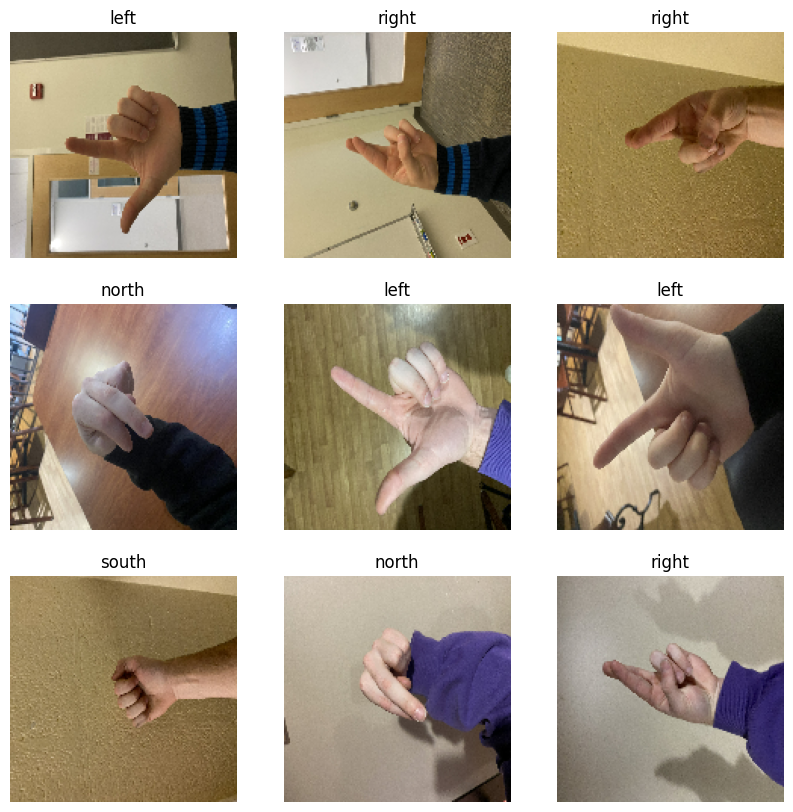

In [10]:

# Get a batch of images and labels
class_names = fine_tune_ds.class_names  # Get class names
for images, labels in fine_tune_ds.take(1):  # Take one batch
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Show first 9 images
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert tensor to image
        plt.title(class_names[labels[i]])  # Show class label
        plt.axis("off")
    plt.show()


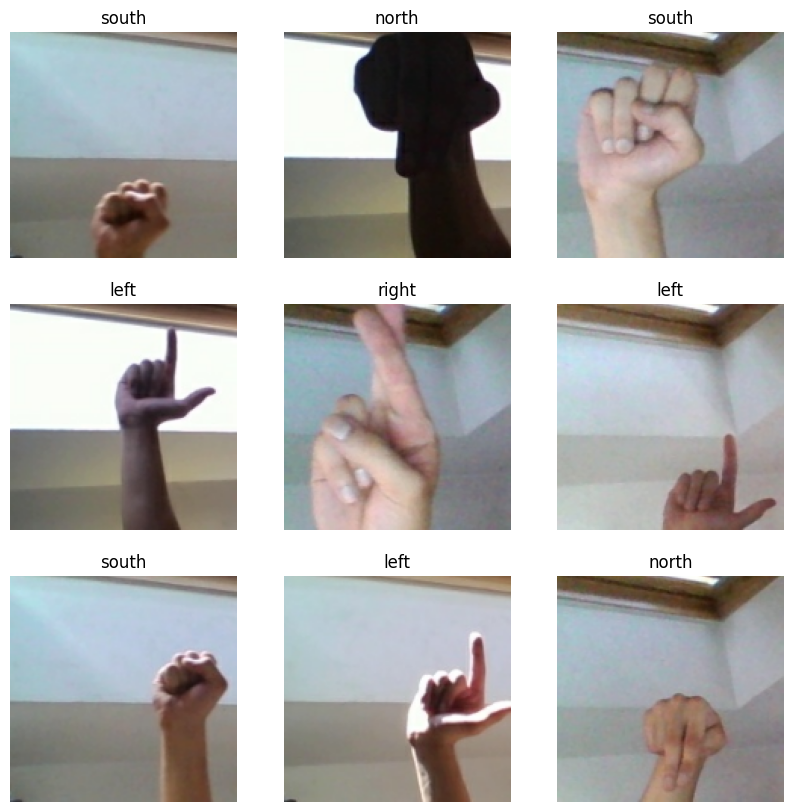

In [14]:

# Get a batch of images and labels
class_names = dataset.class_names  # Get class names
for images, labels in dataset.take(1):  # Take one batch
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Show first 9 images
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert tensor to image
        plt.title(class_names[labels[i]])  # Show class label
        plt.axis("off")
    plt.show()


In [15]:
dataset=dataset.unbatch()
training_ds, validation_ds = tf.keras.utils.split_dataset(
    dataset, left_size=0.8, shuffle=False, seed=None
)
print(f"length training data set: {len(training_ds)}")
print(f"length validation data set: {len(validation_ds)}")
training_ds = training_ds.batch(16)
validation_ds = validation_ds.batch(16)
print(f"# of batch for training data set: {len(training_ds)}")
print(f"# of batch for validation data set: {len(validation_ds)}")

length training data set: 5781
length validation data set: 1445
# of batch for training data set: 362
# of batch for validation data set: 91


Original dataset size: 10
Augmented dataset size: 30
Final dataset size: 40


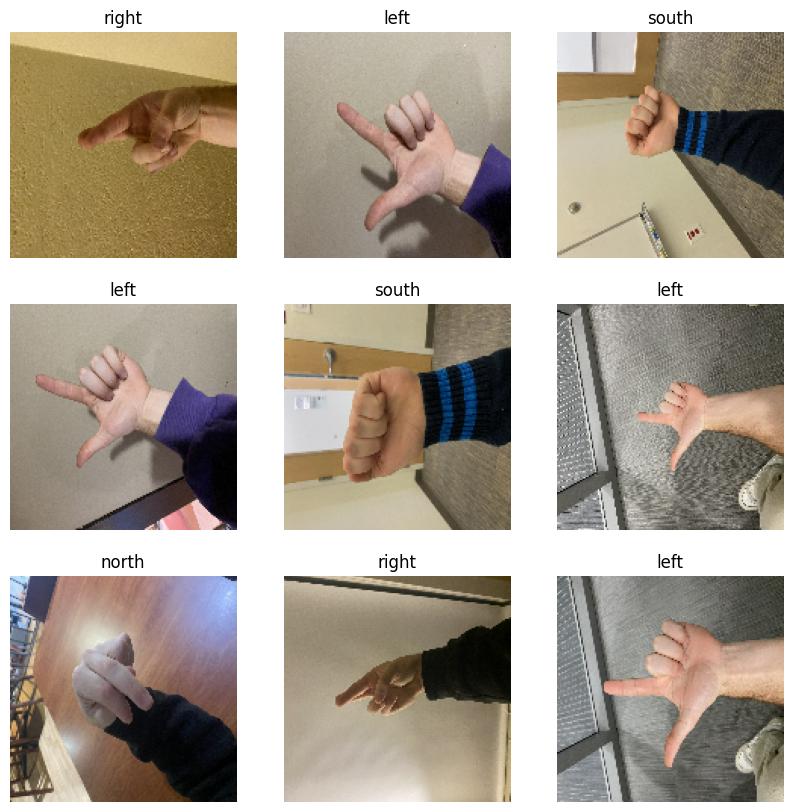

In [16]:


# Define augmentation layers
augmentation_layers = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1),
])

# Function to apply augmentation multiple times per image
def augment_multiple_times(image, label, num_augmentations=3):
    """Applies augmentation multiple times to each image."""
    augmented_images = [augmentation_layers(image) for _ in range(num_augmentations)]
    augmented_labels = [label] * num_augmentations  # Repeat labels
    return tf.data.Dataset.from_tensor_slices((augmented_images, augmented_labels))

# Apply augmentation multiple times and flatten the dataset
augmented_datasets = fine_tune_ds.flat_map(lambda x, y: augment_multiple_times(x, y, num_augmentations=3))

# Combine original dataset with augmented dataset
expanded_training_ds = fine_tune_ds.concatenate(augmented_datasets)

# Check dataset size
print("Original dataset size:", len(list(fine_tune_ds)))
print("Augmented dataset size:", len(list(augmented_datasets)))
print("Final dataset size:", len(list(expanded_training_ds)))

# Verify augmentation by displaying images
for images, labels in expanded_training_ds.take(1):  # Take one batch
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Show first 9 images
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert tensor to image
        plt.title(class_names[labels[i]])  # Show class label
        plt.axis("off")
    plt.show()


In [17]:
expanded_training_ds=expanded_training_ds.unbatch()
exft_training_ds, exft_validation_ds = tf.keras.utils.split_dataset(
    expanded_training_ds, left_size=0.8, shuffle=False, seed=None
)
print(f"length training data set: {len(exft_training_ds)}")
print(f"length validation data set: {len(exft_validation_ds)}")
exft_training_ds = exft_training_ds.batch(16)
exft_validation_ds = exft_validation_ds.batch(16)


length training data set: 512
length validation data set: 128


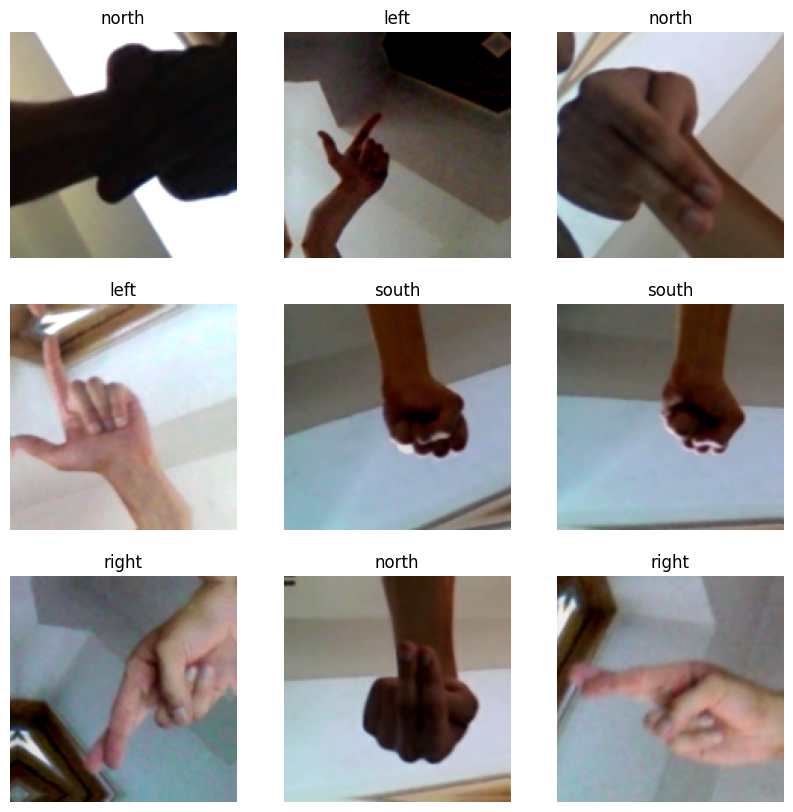

In [18]:
#Augmentation (flips, zoom...)

augmentation_layers = [
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),                           
    layers.RandomContrast(0.2),              
    layers.RandomBrightness(0.2),             
]

def augmentation_layer(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x

training_ds = training_ds.map(lambda x, y: (augmentation_layer(x), y))

for images, labels in training_ds.take(1):  # Take one batch
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Show first 9 images
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert tensor to image
        plt.title(class_names[labels[i]])  # Show class label
        plt.axis("off")
    plt.show()


In [19]:
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)

base_model = keras.applications.DenseNet201(
    weights="imagenet", 
    input_shape=(150, 150, 3),
    classifier_activation="softmax",
    include_top=False
)
base_model.trainable = False

inputs = keras.Input(shape=(150, 150, 3))

# x = data_augmentation(inputs)
x = scale_layer(inputs)

# Keep Xception model trainable

# Pass through Xception
x = base_model(x)

# Global Average Pooling to flatten features
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)

# Fully connected layer (256 neurons, non-trainable)
dense_layer = layers.Dense(256, activation="relu")
dense_layer.trainable = True  # Freeze this layer
x = dense_layer(x)
x = layers.Dropout(0.3)(x)

# Fully connected layer (256 neurons, non-trainable)
dense_layer = layers.Dense(128, activation="relu")
dense_layer.trainable = True  # Freeze this layer
x = dense_layer(x)

x = layers.Dropout(0.3)(x)  # Prevent overfitting

# Final classification layer (4 classes, non-trainable)
output_layer = layers.Dense(4, activation="softmax")
output_layer.trainable = True 
output = output_layer(x)

# Create the model
model = keras.Model(inputs, output)

# Show trainable layers summary
model.summary(show_trainable=True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_2 (InputLayer)  │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling (Rescaling)       │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ densenet201 (Functional)    │ (None, 4, 4, 1920)    │ 18,321,984 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 1920)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 1920)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 256)           │    491,776 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_1 (Dropout)         │ (None, 256)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_1 (Dense)             │ (None, 128)           │     32,896 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_2 (Dropout)         │ (None, 128)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_2 (Dense)             │ (None, 4)             │        516 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 18,847,172 (71.90 MB)

 Trainable params: 525,188 (2.00 MB)

 Non-trainable params: 18,321,984 (69.89 MB)

In [30]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early Stopping: Stops training if validation loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(
    monitor="val_loss",   
    patience=5,           
    restore_best_weights=True  
)

# Learning Rate Scheduler: Reduces LR when validation loss stops improving
lr_schedule = ReduceLROnPlateau(
    monitor="val_loss",   
    factor=0.5,          
    patience=3,           
    verbose=1,          
    min_lr=1e-7           
)


In [31]:
model.compile(
    optimizer=keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)
print("Fit model on training data")
history = model.fit(
    training_ds,
    epochs=20,
)

Fit model on training data
Epoch 1/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 58s 113ms/step - loss: 1.0356 - sparse_categorical_accuracy: 0.6140
Epoch 2/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 34s 95ms/step - loss: 0.4504 - sparse_categorical_accuracy: 0.8406
Epoch 3/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 35s 96ms/step - loss: 0.3449 - sparse_categorical_accuracy: 0.8798
Epoch 4/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 34s 94ms/step - loss: 0.3090 - sparse_categorical_accuracy: 0.8951
Epoch 5/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 35s 96ms/step - loss: 0.2790 - sparse_categorical_accuracy: 0.9089
Epoch 6/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 35s 96ms/step - loss: 0.2767 - sparse_categorical_accuracy: 0.9145
Epoch 7/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 35s 96ms/step - loss: 0.2782 - sparse_categorical_accuracy: 0.9138
Epoch 8/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 35s 95ms/step - loss: 0.2684 - sparse_categorical_accuracy: 0.9168
Epoch 9/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 34s 95ms/step - loss: 0.2410 - sparse_categorical_accuracy: 0.9318
Epoch 10/

In [52]:
print(history.history)

{'loss': [1.5538971424102783, 1.3453704118728638, 1.3566316366195679, 1.2746846675872803, 1.3020356893539429, 1.289331078529358, 1.2537935972213745, 1.23114812374115, 1.2470370531082153, 1.1585588455200195], 'sparse_categorical_accuracy': [0.3370535671710968, 0.390625, 0.3727678656578064, 0.4084821343421936, 0.4241071343421936, 0.4330357015132904, 0.4107142984867096, 0.46875, 0.4375, 0.4933035671710968]}


In [57]:
model.save("denseNet201.keras")

In [55]:
model.save_weights("denseNet201_weights.weights.h5")



In [68]:
#Try to predict an image of my data set with model trained with kaggle dataset
img_path = "my_images/south/IMG_2396.jpg"
img_size = (150, 150)  
img = image.load_img(img_path, target_size=img_size)
img_array = image.img_to_array(img)

img_array = (img_array / 127.5) - 1.0  

# Expand dimensions to match model's expected input shape (batch size of 1)
img_array = np.expand_dims(img_array, axis=0)
prediction = model.predict(img_array)
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[[9.9999964e-01 1.4263572e-10 9.5546135e-08 2.1635934e-07]]


In [20]:
from sklearn.metrics import classification_report, f1_score, recall_score
import numpy as np

# Assuming 'model' is your trained model and 'fine_tune_ds' is your dataset

# Get the true labels and predictions
y_true = np.concatenate([y for x, y in validation_ds], axis=0)  # True labels
y_pred_probs = model.predict(validation_ds)  # Predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels

# Generate the classification report
# report = classification_report(y_true, y_pred, target_names=["Class 0", "Class 1", "Class 2", "Class 3"])
fscore = f1_score(y_true, y_pred, average='weighted')
print(fscore)
recall = f1_score(y_true, y_pred, average='weighted')
print(recall)
# print(report)


91/91 ━━━━━━━━━━━━━━━━━━━━ 17s 98ms/step
0.9800057432606377
0.9800057432606377


In [21]:
loss, accuracy = model.evaluate(exft_validation_ds)
print(f'Validation Accuracy: {accuracy}')
print(f'Validation Loss: {loss}')


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.5066 - sparse_categorical_accuracy: 0.5653
Validation Accuracy: 0.5703125
Validation Loss: 2.4951963424682617


In [22]:
loss, accuracy = model.evaluate(combination_ds)
print(f'Validation Accuracy: {accuracy}')
print(f'Validation Loss: {loss}')


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - loss: 2.4527 - sparse_categorical_accuracy: 0.6873
Validation Accuracy: 0.7124999761581421
Validation Loss: 2.1993374824523926


In [19]:
loss, accuracy = model.evaluate(validation_ds)
print(f'Validation Accuracy: {accuracy}')
print(f'Validation Loss: {loss}')


91/91 ━━━━━━━━━━━━━━━━━━━━ 22s 109ms/step - loss: 0.0405 - sparse_categorical_accuracy: 0.9812
Validation Accuracy: 0.9799308180809021
Validation Loss: 0.05084043741226196


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


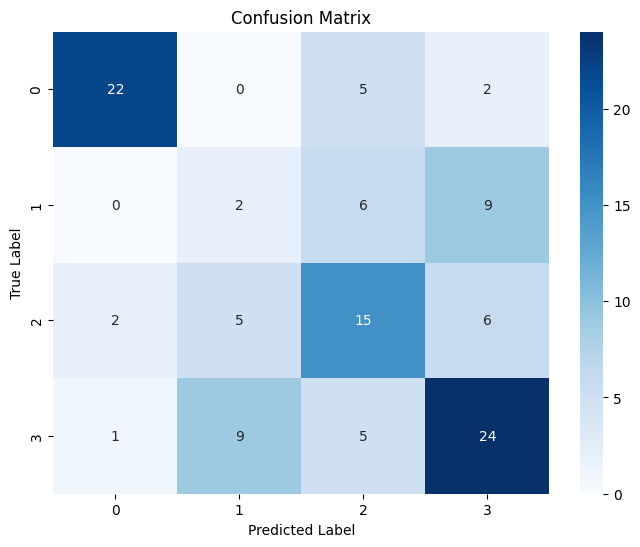

In [19]:
y_true = []
y_pred = []

for images, labels in exft_validation_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))  # Convert one-hot to class index
    y_true.extend(labels)  # Get true labels

# Create a confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

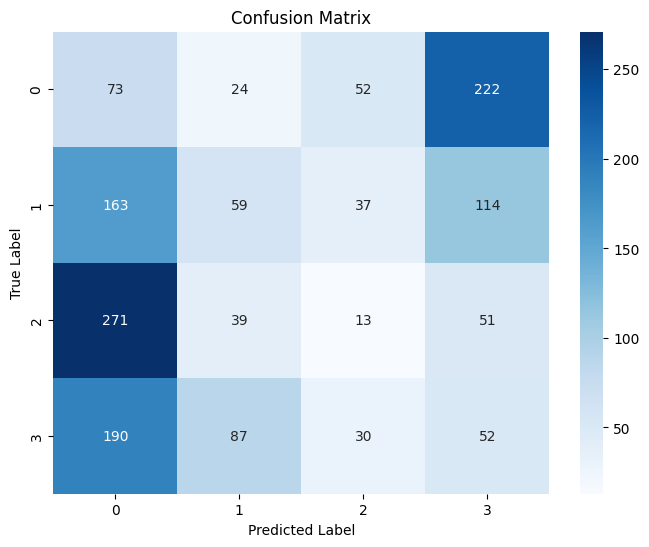

In [74]:
#my images
y_true = []
y_pred = []

for images, labels in validation_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))  # Convert one-hot to class index
    y_true.extend(labels)  # Get true labels

# Create a confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [42]:
loss, accuracy = model.evaluate(fine_tune_ds)
print(loss, accuracy)

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 344ms/step - loss: 4.4498 - sparse_categorical_accuracy: 0.2541
4.888895034790039 0.19736842811107635


In [26]:
model.save('model_v0test.keras')

In [102]:
# Load the image
img_path = "test_image.jpg"  # Update with your image path
img_size = (150, 150)  # Change this to match your model's input shape

# Load image and resize
img = image.load_img(img_path, target_size=img_size)

# Convert image to array
img_array = image.img_to_array(img)

img_array = (img_array / 127.5) - 1.0  

# Expand dimensions to match model's expected input shape (batch size of 1)
img_array = np.expand_dims(img_array, axis=0)
prediction = model.predict(img_array)
print(prediction)
k=None
for count, i in enumerate(prediction[0]):
    if i>0.9:
        k = count
print(k)
        


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[[1.29627775e-08 3.15901634e-05 2.66294256e-02 9.73338962e-01]]
3


In [21]:
model_without_last_layer = Model(inputs=model.input, outputs=model.layers[-4].output)

# Check the new model summary to confirm the last layer is removed
model_without_last_layer.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet201 (Functional)        │ (None, 4, 4, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       491,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,813,760 (71.77 MB)

 Trainable params: 491,776 (1.88 MB)

 Non-trainable params: 18,321,984 (69.89 MB)

In [22]:
model_without_last_layer.save('new1_denseNet201.keras')

In [28]:
dense_layer = model.layers[-5]
dense_layer.trainable=False
dense_layer = model.layers[-3]
dense_layer.trainable=False
ouput_layer = model.layers[-1]
output_layer.trainable=False


model.summary(show_trainable=True)

AttributeError: 'list' object has no attribute 'layers'

In [26]:
model.compile(
    optimizer=keras.optimizers.Adam(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

In [27]:
epochs = 40
print("Fitting the end-to-end model")
history = model.fit(exft_training_ds, epochs=epochs, callbacks=[early_stopping, lr_schedule])

Fitting the end-to-end model
Epoch 1/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - loss: 1.0563 - sparse_categorical_accuracy: 0.5793 - learning_rate: 0.0010
Epoch 2/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.0310 - sparse_categorical_accuracy: 0.5662 - learning_rate: 0.0010
Epoch 3/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.0365 - sparse_categorical_accuracy: 0.5738 - learning_rate: 0.0010
Epoch 4/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.0110 - sparse_categorical_accuracy: 0.5540 - learning_rate: 0.0010
Epoch 5/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.0163 - sparse_categorical_accuracy: 0.6012 - learning_rate: 0.0010
Epoch 6/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.0263 - sparse_categorical_accuracy: 0.5847 - learning_rate: 0.0010
Epoch 7/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9921 - sparse_categorical_accuracy: 0.5812 - learning_rate: 0.0010
Epoch 8/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9553 - sparse

In [145]:
print(history.history)

{'loss': [1.1838654279708862, 1.192270040512085, 1.1470061540603638, 1.2187825441360474, 1.1340856552124023, 1.1331470012664795, 1.1343953609466553, 1.2317911386489868, 1.1584259271621704, 1.2225767374038696, 1.157754898071289, 1.157417893409729, 1.2054497003555298, 1.1809741258621216, 1.188947081565857, 1.154783010482788, 1.1755268573760986, 1.1431061029434204, 1.1218066215515137, 1.118237853050232], 'sparse_categorical_accuracy': [0.4285714328289032, 0.4196428656578064, 0.4285714328289032, 0.4017857015132904, 0.4821428656578064, 0.5, 0.4642857015132904, 0.4196428656578064, 0.4821428656578064, 0.4107142984867096, 0.4375, 0.4107142984867096, 0.4732142984867096, 0.4285714328289032, 0.4285714328289032, 0.4553571343421936, 0.4464285671710968, 0.4285714328289032, 0.4375, 0.4642857015132904], 'learning_rate': [0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513,

In [28]:
loss, accuracy = model.evaluate(exft_validation_ds)
print(loss, accuracy)

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.8620 - sparse_categorical_accuracy: 0.6406
0.8799609541893005 0.609375


In [29]:
loss, accuracy = model.evaluate(combination_ds)
print(loss, accuracy)

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - loss: 0.7032 - sparse_categorical_accuracy: 0.8066
0.6823755502700806 0.8343750238418579


In [30]:
loss, accuracy = model.evaluate(validation_ds)
print(loss, accuracy)

91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 0.7655 - sparse_categorical_accuracy: 0.7937
0.7762752771377563 0.7882353067398071


In [39]:
img_path = "south_test.jpg"
img_size = (150, 150)  
img = image.load_img(img_path, target_size=img_size)
img_array = image.img_to_array(img)

img_array = (img_array / 127.5) - 1.0  

# Expand dimensions to match model's expected input shape (batch size of 1)
img_array = np.expand_dims(img_array, axis=0)
prediction = model.predict(img_array)
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
[[0.01799386 0.4611573  0.05210061 0.46874818]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


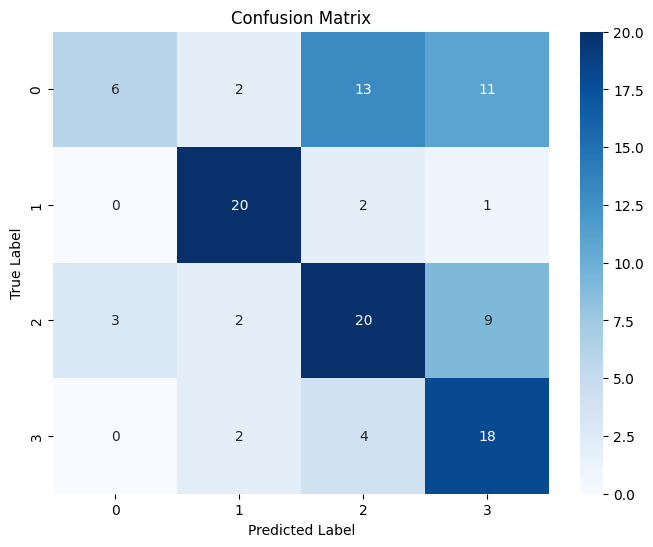

In [39]:
#my images
y_true = []
y_pred = []

for images, labels in exft_validation_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))  # Convert one-hot to class index
    y_true.extend(labels)  # Get true labels

# Create a confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
